# Recurrent neural networks


### Time Interval Categorization Task

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn

from scipy.optimize import root
from sklearn.decomposition import PCA

import tasks
import models
import model_parameters
from helpers import *

In [2]:
#Alpha
model_name = "alpha"
task_name = "TICT"
model, task, parameters = load_model(model_name, task_name)

C:\Users\user\OneDrive\Desktop\work\Recurrent-Neural-Networks-for-cognitive-tasks\helpers.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.lo

## Analysis

In [8]:
def trials_analysis(model, data, ends, vanilla_euler = False):
    with torch.no_grad():
        scores = torch.zeros(targets.shape)
        hidden = torch.zeros(batch_size, task.lentv, hidden_size)
        for b in range(batch_size):
            if vanilla_euler:
                scores1, hidden1 = model.foward_euler(data, ends, b, alpha)
            else:
                scores1, hidden1 = model(data, ends, b)
                hidden[b, :, :] = hidden1
                scores1[0, :int(starts[0, b] - 1), :] *= 0
                scores[b, :int(ends[0, b]), :] = scores1

    return scores, hidden

plot_T2 = task.time2indx(0.2)

delay_arange = np.round(np.arange(0.2, 1.1, 0.1), 2)
t_responses = [0.6, 0.9, 1.2]
t_go_cue_down = 2. # 0.3 #
t_ext = 0.5

tau = task.tau
n_inputs = task.n_inputs
batch_size = parameters["batch_size"]
learning_rate = parameters["learning_rate"]
hidden_size = parameters["hidden_size"]

## Extrapolation
### Changed delay time

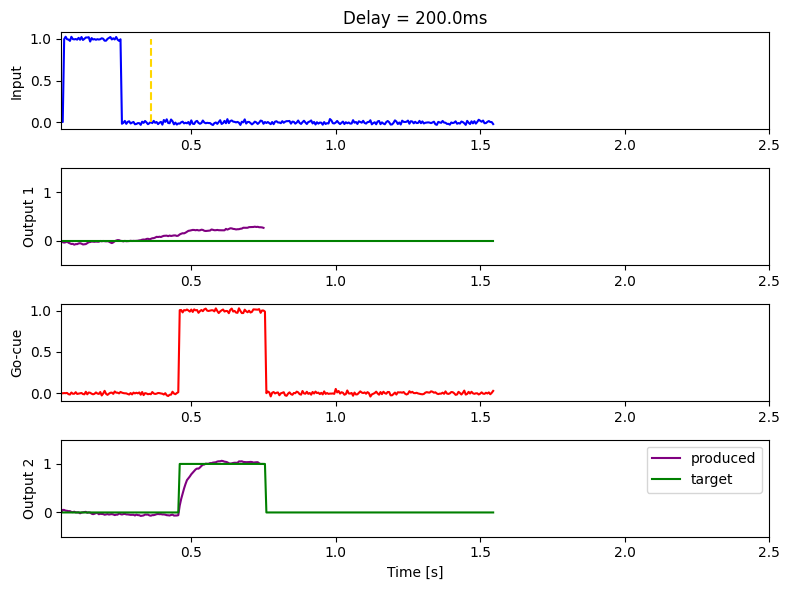

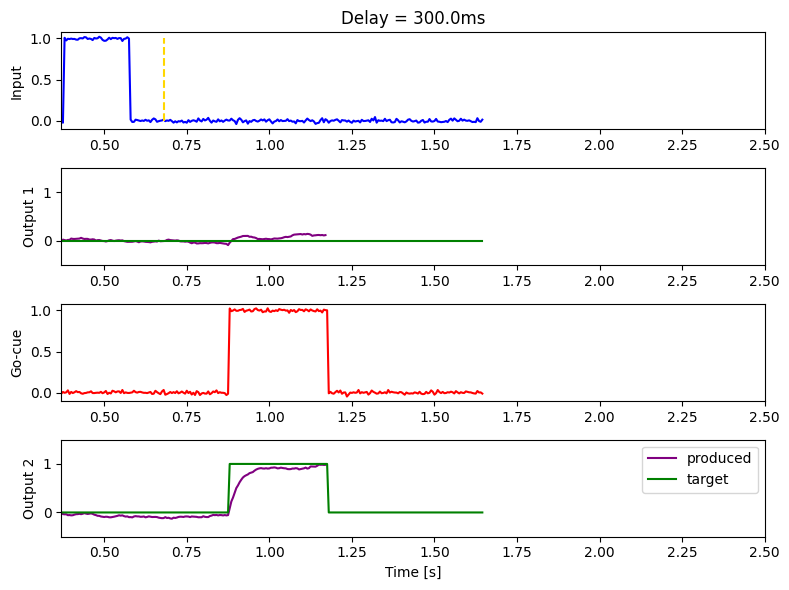

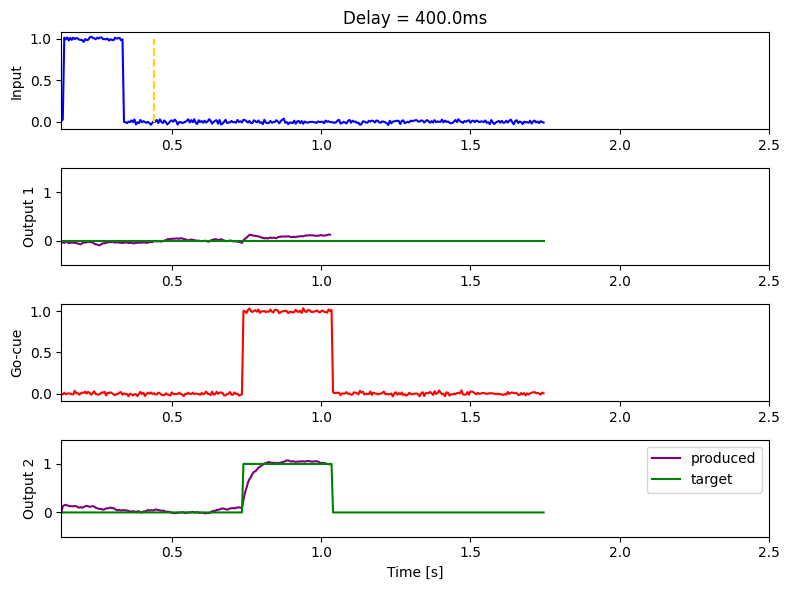

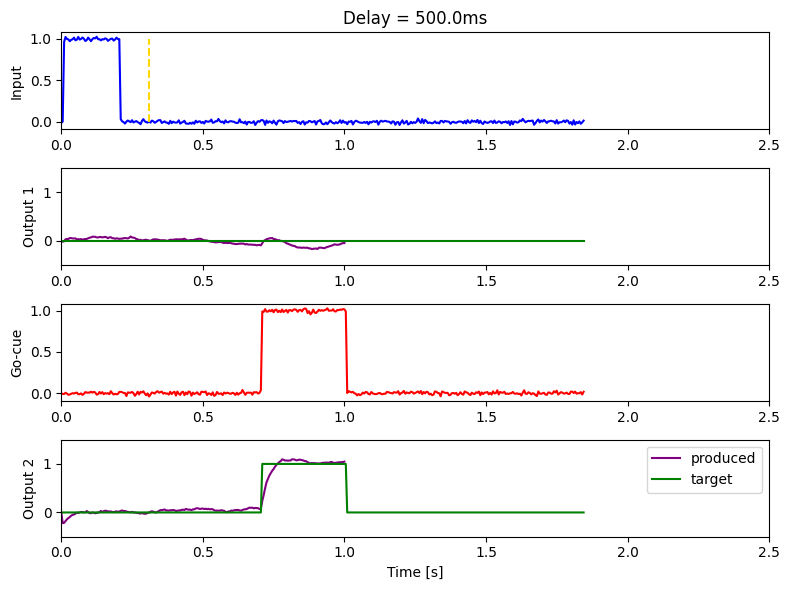

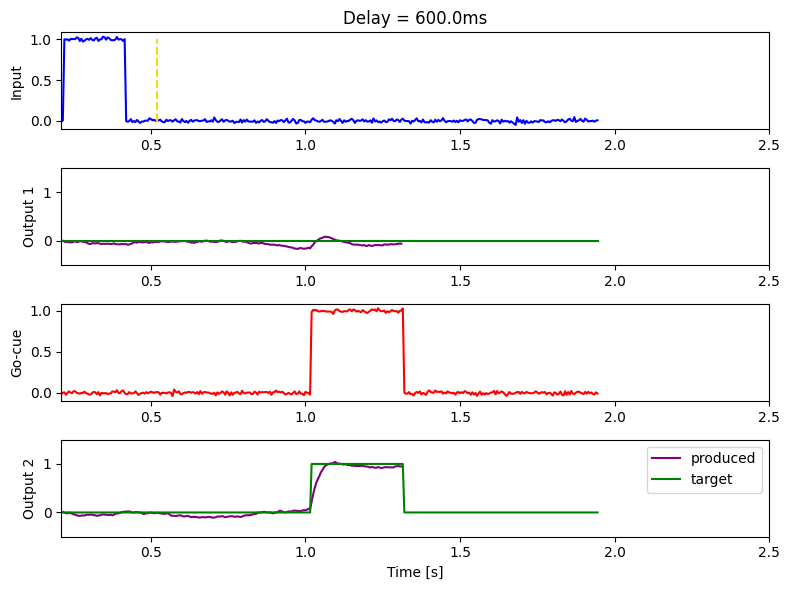

KeyboardInterrupt: 

In [ ]:
t_original = task.t_max_delay
for t_max_delay in delay_arange:
    task.t_max_delay = t_max_delay
    task.t_final = task.t_max_start + task.t_max_stim1 + task.t_max_delay + task.t_response
    task.create_trials()

    inputs, labels, starts, ends, Ts, obj = task.get_random_trials()
    T2s = Ts[1, :]
    T3s = Ts[2, :]
    data, targets = task.get_data(inputs, labels)

    scores, _ = trials_analysis(model, data, ends)

    title = "Delay = " + str(t_max_delay * 1000) + "ms"
    for n in range(batch_size):
        if T2s[n] == plot_T2:
            break

    start = (starts[0,n] - 2) * step
    task.plot_trial(scores, inputs, labels, starts, ends, n, title, xlims = [start, 2.5])

task.t_max_delay = t_original
task.t_final = task.t_max_start + task.t_max_stim1 + task.t_max_delay + task.t_response
task.create_trials()

### Change response time

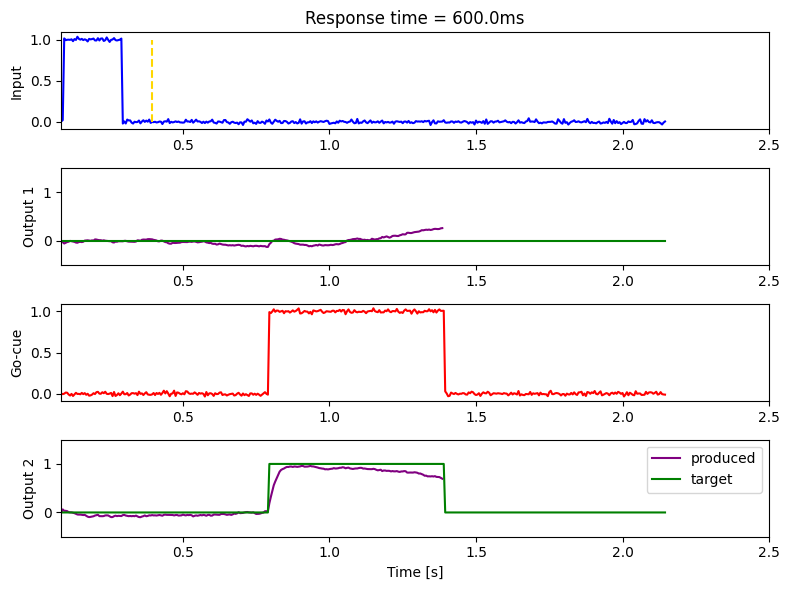

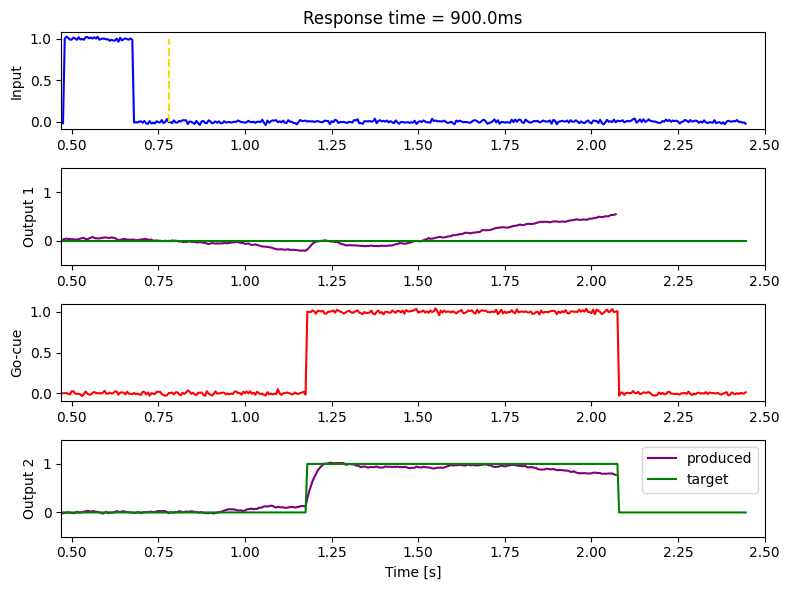

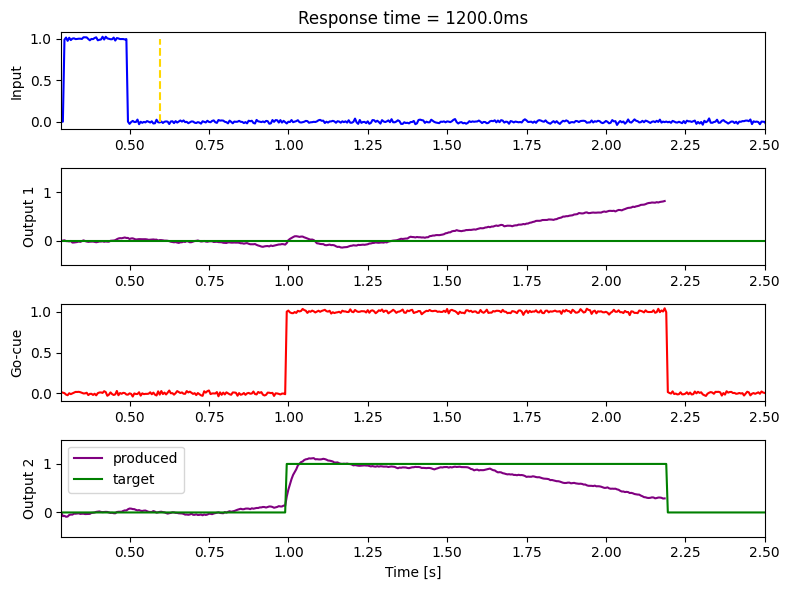

In [ ]:
t_original = task.t_response
for t_response in t_responses:
    task.t_response = t_response
    task.t_final = task.t_max_start + task.t_max_stim1 + task.t_max_delay + task.t_response
    task.create_trials()

    inputs, labels, starts, ends, Ts, obj = task.get_random_trials()
    T2s = Ts[1, :]
    T3s = Ts[2, :]
    data, targets = task.get_data(inputs, labels)

    scores, _ = trials_analysis(model, data, ends)

    title = "Response time = " + str(t_response * 1000) + "ms"
    for n in range(batch_size):
        if T2s[n] == plot_T2:
            break

    start = (starts[0,n] - 2) * task.step
    task.plot_trial(scores, inputs, labels, starts, ends, n, title, xlims = [start, 2.5])

task.t_response = t_original
task.t_final = task.t_max_start + task.t_max_stim1 + task.t_max_delay + task.t_response
task.create_trials()

### State Similarity

In [ ]:
# Add extra time after the trial end
task.t_final = task.t_max_start + task.t_max_stim1 + \
    task.t_max_delay + task.t_response + t_go_cue_down
task.create_trials()
inputs, labels, starts, ends, Ts, obj = task.get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = task.get_data(inputs, labels)

for n in range(batch_size):
    if T2s[n] == plot_T2:
        break

ends[0, n] += task.time2indx(t_go_cue_down)
scores, hidden = trials_analysis(model, data, ends, vanilla_euler=False)

#Cosine similarity

len_trial = ends[0,n]
CS = np.zeros((len_trial, len_trial))
for t1 in range(len_trial):
    for t2 in range(t1, len_trial):
        n1 = hidden[n, t1, :]
        n2 = hidden[n, t2, :]
        CS[t1, t2] = np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2))
        CS[t2, t1] = CS[t1, t2]

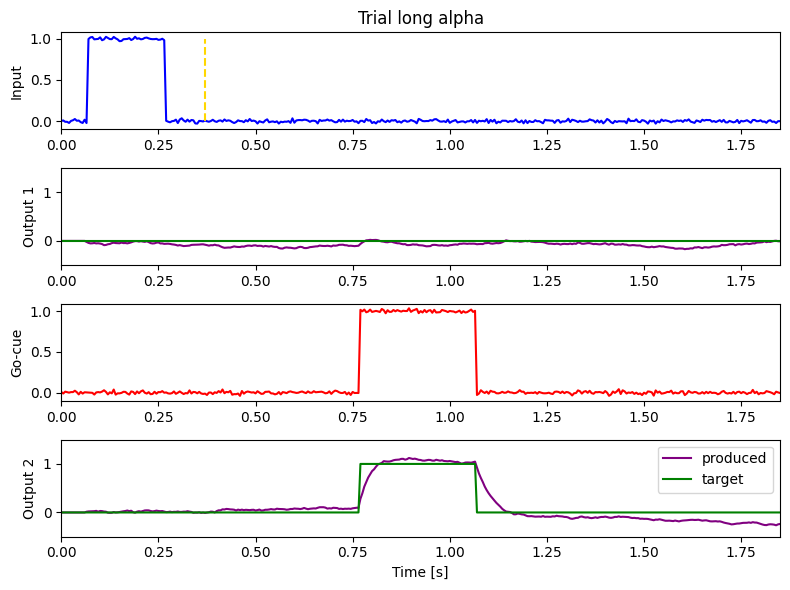

In [ ]:
title = "Trial long alpha"
task.plot_trial(scores, inputs, labels, starts, ends, n, title)

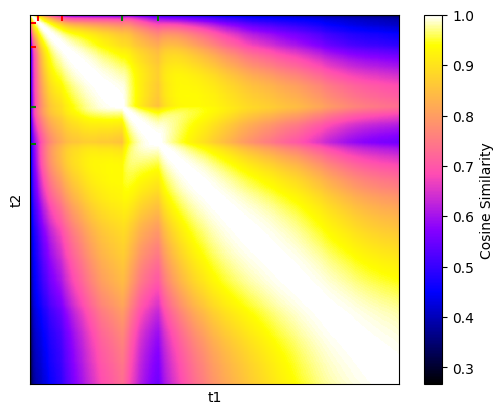

In [ ]:
len_line = 10

plt.imshow(CS[1:,1:], cmap="gnuplot2")
plt.vlines(Ts[0,n] - 1, 0, len_line, linestyle="--", color="red")
plt.hlines(Ts[0,n] - 1, 0, len_line, linestyle="--", color="red")
plt.vlines(Ts[0,n] + Ts[1,n] - 1, 0, len_line, linestyle="--", color="red")
plt.hlines(Ts[0,n]  + Ts[1,n] - 1, 0, len_line, linestyle="--", color="red")
plt.vlines(Ts[4,n] - 1, 0, len_line, linestyle="--", color="green")
plt.hlines(Ts[4,n] - 1, 0, len_line, linestyle="--", color="green")
plt.vlines(Ts[3,n] - 1, 0, len_line, linestyle="--", color="green")
plt.hlines(Ts[3,n] - 1, 0, len_line, linestyle="--", color="green")

plt.xticks([])
plt.yticks([])
plt.xlabel("t1")
plt.ylabel("t2")
plt.colorbar(label="Cosine Similarity")
plt.show()

### Two trials in a row

In [ ]:
inputs, labels, starts, ends, Ts, obj = get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = get_data(inputs, labels)

for n in range(batch_size):
  if T2s[n] == plot_T2:
    break

end2 = torch.tensor([ends[0, n] + ends[0, n + 1]]).reshape(1, 1)
data2 = torch.cat((data[n, :ends[0, n], :],
                  data[n + 1, :ends[0, n + 1], :]), dim = 0)
data2 = data2.unsqueeze(0)
scores, hidden = model(data2, end2, 0)

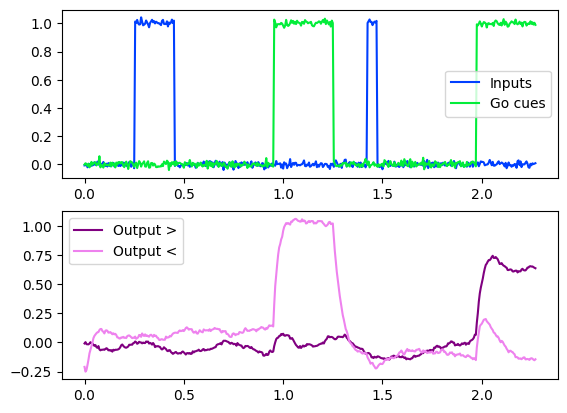

In [ ]:
time2 = np.arange(0, int(end2[0])) * step
plt.subplot(211)
plt.plot(time2, data2[0, :, :].numpy())
plt.legend(["Inputs", "Go cues"])
plt.subplot(212)
plt.plot(time2, scores[0, :, 0].detach().numpy(), color="purple")
plt.plot(time2, scores[0, :, 1].detach().numpy(), color="violet")
plt.legend(["Output >", "Output <"])
plt.show()

## Population analysis
### Stability

In [4]:
def alpha_eq(x, S, W_rec, W_in, u, b_rec, tau):
    x = x.reshape(-1, 1)
    return ((-x + S(W_rec @ x + W_in @ u + b_rec)) / tau).flatten()

def vanilla_eq(x, S, W_rec, W_in, u, b_rec, tau):
    x = x.reshape(-1, 1)
    return ((-x + W_rec @ S(x) + W_in @ u + b_rec) / tau).flatten()

def J_alpha(x, S_prime, W_rec, W_in, u, b_rec, tau):
    x = x.reshape(-1,1)
    S_term = np.diag(S_prime(W_rec @ x + W_in @ u + b_rec).flatten())
    return (-np.eye(W_rec.shape[0]) + S_term @ W_rec) / tau

def J_vanilla(x, S_prime, W_rec, W_in, u, b_rec, tau):
    x = x.reshape(-1,1)
    S_term = np.diag(S_prime(x).flatten())
    return (-np.eye(W_rec.shape[0]) + W_rec @ S_term) / tau

def stable_point_type(x, J):
    Jacobian = J(x, S_prime, W_rec, W_in, u, b_rec, tau)
    J_eigv, J_eigvec = np.linalg.eig(Jacobian)
    J_eigv_n = np.count_nonzero(np.real(J_eigv) < 0)
    J_eigv_p = np.count_nonzero(np.real(J_eigv) > 0)

    if J_eigv_p == 0:
        print("Atractor\n\n")
    elif J_eigv_n == 0:
        print("Repeler\n\n")
    else:
        print(f"Saddle, negative:{J_eigv_n}, positive:{J_eigv_p}\n\n")

    return J_eigv, J_eigvec

if model_name == "vanilla":
    eq = vanilla_eq
    J = J_vanilla
    W_rec = model.i2h.weight[:, n_inputs:].detach().numpy()
    W_in = model.i2h.weight[:, :n_inputs].detach().numpy()
    b_rec = model.i2h.bias.detach().numpy().reshape(-1, 1)
else:
    eq = alpha_eq
    J = J_alpha
    W_rec = model.W_rec.detach().numpy()
    W_in =  model.W_in.detach().numpy()
    b_rec = model.b.detach().numpy().reshape(-1, 1)

S = lambda x: np.where(x < 20, np.log(1 + np.exp(x)), x)
S_prime = lambda x: 1 / (1 + np.exp(-x))
u = np.zeros((n_inputs, 1))

x0 = np.zeros((hidden_size, 1))
root_dx = root(eq, x0, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
J_eigv, J_eigvec = stable_point_type(root_dx.x, J)
root_dx

Atractor




 message: Both actual and predicted relative reductions in the sum of squares
            are at most 0.000000
 success: True
  status: 1
     fun: [-7.984e-03 -8.144e-03 ...  2.706e-02 -1.941e-02]
       x: [ 2.883e-01  2.527e-01 ...  4.161e-01  2.630e-01]
   cov_x: [[ 2.904e+04  3.011e+04 ...  2.841e+04  2.387e+04]
           [ 3.011e+04  3.121e+04 ...  2.945e+04  2.475e+04]
           ...
           [ 2.841e+04  2.945e+04 ...  2.779e+04  2.335e+04]
           [ 2.387e+04  2.475e+04 ...  2.335e+04  1.962e+04]]
    nfev: 6179
    fjac: [[ 3.562e+01  2.199e-01 ...  1.208e-01  1.589e-01]
           [ 2.200e-01  3.494e+01 ...  1.038e-01  1.541e-01]
           ...
           [ 1.208e-01  1.039e-01 ...  2.806e-01 -2.105e-02]
           [ 1.589e-01  1.541e-01 ...  3.738e-03 -2.246e-05]]
    ipvt: [  3  15 ... 161 192]
     qtf: [-2.801e-07 -7.440e-07 ... -2.372e-04  2.139e+00]

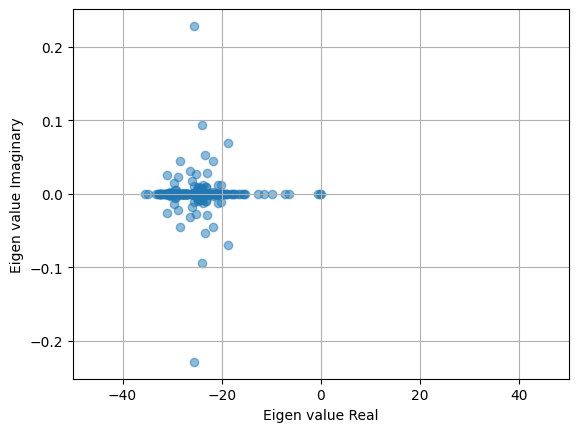

In [17]:
def plot_eigenvalue_histogram(J_eigv):
    plt.scatter(J_eigv.real, J_eigv.imag, marker="o", alpha=0.5)
    plt.xlabel("Eigen value Real")
    plt.ylabel("Eigen value Imaginary")
    plt.xlim([-50,50])
    plt.grid(visible=True)
    plt.show()

plot_eigenvalue_histogram(J_eigv)

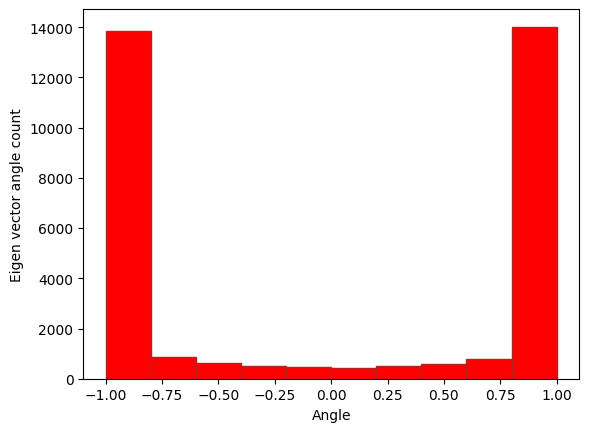

In [6]:
def plot_eigenvector_histogram(J_eigvec):
    angles = np.array([])
    for i in range(J_eigvec.shape[1]):
        for j in range(i + 1, J_eigvec.shape[1]):
            angle = np.vdot(J_eigvec[:,i], J_eigvec[:,j])
            angle /= np.linalg.norm(angle)
            #angle = np.arccos(angle) * 180 / np.pi
            angles = np.append(angles, angle)

    plt.hist(angles.real, facecolor="red", edgecolor="firebrick")
    plt.ylabel("Eigen vector angle count")
    plt.xlabel("Angle")
    plt.show()

plot_eigenvector_histogram(J_eigvec)

### PCA

In [33]:
batch_size = 1000
inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = task.get_data(inputs, labels)

scores, hidden = trials_analysis(model, data, ends)

#Get the delay
len_delay = task.time2indx(task.t_max_delay)
hidden_delay = np.zeros((batch_size, len_delay, hidden_size))
for b in range(batch_size):
    hidden_delay = hidden[:, Ts[0, b] + Ts[1, b]:Ts[4, b], :] \
                  .detach().numpy()

#Get class avg
n_class = len(task.stim1s)
class_avg = np.zeros((n_class, len_delay, hidden_size))
for ti, t in enumerate(task.stim1s):
    class_t = np.where(Ts[1, :] == task.time2indx(t))[0]
    class_avg[ti, :, :] = np.mean(hidden_delay[class_t, :, :], axis = 0)

# PCA
n_components = 5
PCA_data = class_avg.reshape(-1, hidden_size)
pca = PCA(n_components = n_components)
pca.fit(PCA_data)
principal_components = pca.components_

print("Principal components shape:", principal_components.shape)

Principal components shape: (5, 256)


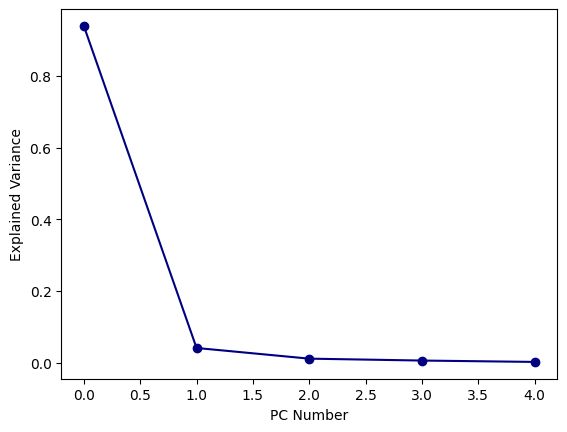

In [34]:
exp_var = pca.explained_variance_ratio_

plt.plot(exp_var, marker = "o", color = "navy")
plt.ylabel("Explained Variance")
plt.xlabel("PC Number")
plt.show()

In [12]:
import matplotlib.colors as mcolors

start_color = "#caf0f8" # Dark blue
end_color = "#03045e"    # Light blue
cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient",
 [start_color, end_color])
c_vec = [cmap(i / (n_class - 1)) for i in range(n_class)]

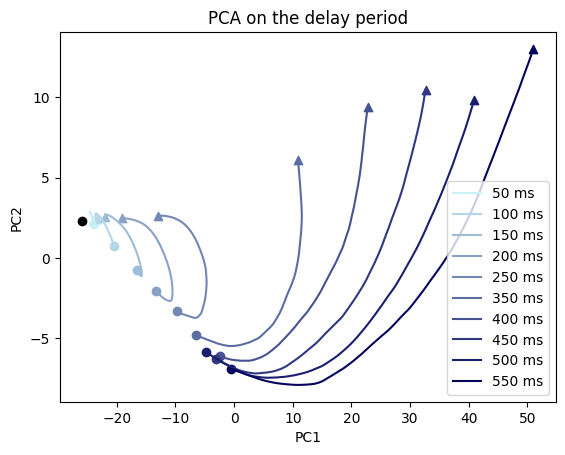

In [35]:
projected_data = pca.transform(PCA_data)
projected_data = projected_data.reshape(n_class, len_delay, n_components)

for c in range(n_class):
    plt.plot(projected_data[c, :, 0], projected_data[c, :, 1], color = c_vec[c],
           label= str(int(task.stim1s[c]*1000)) + " ms")
    plt.scatter(projected_data[c, 0, 0], projected_data[c, 0, 1], marker="o",
              color = c_vec[c])
    plt.scatter(projected_data[c, -1, 0], projected_data[c, -1, 1], marker="^",
              color = c_vec[c])

stable_point = pca.transform(root_dx.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black")
plt.title("PCA on the delay period")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

### Simulate more states

In [41]:
def euler(x0, x_dot, parm, steps = 1000, dt=1e-3):
    x = np.copy(x0)
    xs = np.zeros((steps, *x0.shape))
    for step in range(steps):
        xs[step, :] = x
        x += dt*x_dot(x, *parm)

    return xs

n_seeds = 20
t = 80
diff_vec = class_avg[-1, t, :] - class_avg[0, t, :]
seeds = class_avg[0, t, :] + \
        np.linspace(0, 1, n_seeds).reshape(-1, 1) * diff_vec

n_steps = 1000
trajectories = np.zeros((n_steps, n_seeds, hidden_size))

for s in range(n_seeds):
    trajectories[:, s, :] = euler(seeds[s, :], eq,
                                (S, W_rec, W_in, u, b_rec, tau), steps = n_steps)

success
Saddle, negative:255, positive:1




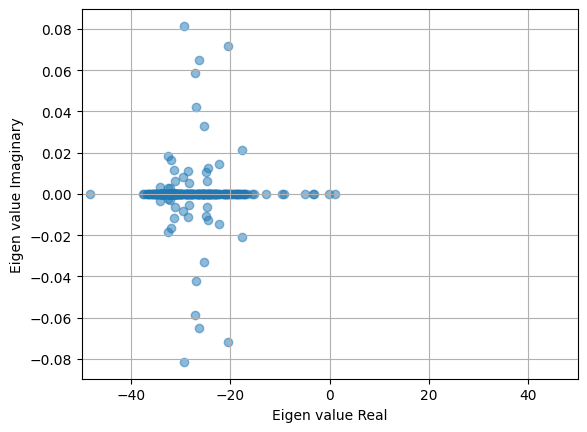

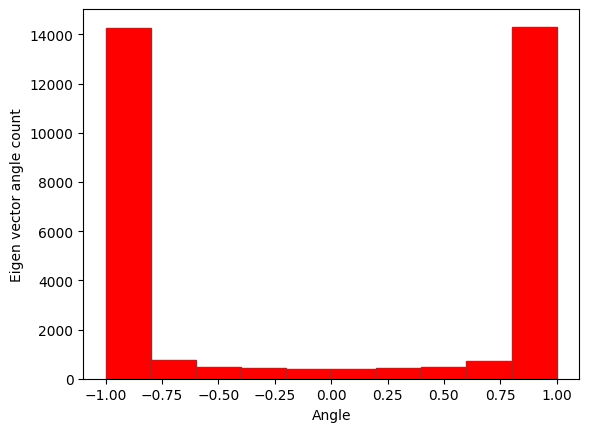

In [18]:
# The search for the separatrix

s = 13 # trajectory near the separatrix
for t in range(n_steps):
    x0_s = trajectories[t, s, :].reshape(-1, 1)
    root_dx_s = root(alpha_eq, x0_s, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
    if not np.allclose(root_dx.x, root_dx_s.x, rtol=1e-1):
        print("success")
        J_eigv2, J_eigvec2 = stable_point_type(root_dx_s.x, J)
        break

plot_eigenvalue_histogram(J_eigv2)
plot_eigenvector_histogram(J_eigvec2)

In [ ]:
# End attractor

s = -1 # end trajectory
for t in np.arange(n_steps - 1, 0, -int(n_steps/20)):
    x0_s = trajectories[t, s, :].reshape(-1, 1)
    root_dx_e = root(alpha_eq, x0_s, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
    if not np.allclose(root_dx.x, root_dx_e.x, rtol=1e-1) and \
      not np.allclose(root_dx_s.x, root_dx_e.x, rtol=1e-1):
        print("success")
        _ = stable_point_type(root_dx_e.x, J)
        break


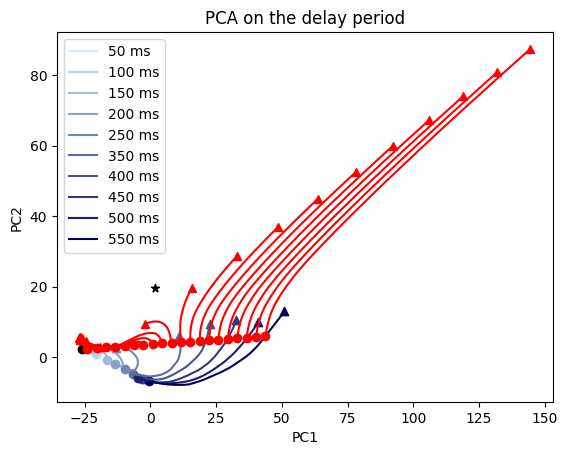

In [42]:
for c in range(n_class):
    plt.plot(projected_data[c, :, 0], projected_data[c, :, 1], color = c_vec[c],
           label= str(int(task.stim1s[c]*1000)) + " ms")
    plt.scatter(projected_data[c, 0, 0], projected_data[c, 0, 1], marker="o",
              color = c_vec[c])
    plt.scatter(projected_data[c, -1, 0], projected_data[c, -1, 1], marker="^",
              color = c_vec[c])

for s in np.arange(0, n_seeds):
    projected_tra = pca.transform(trajectories[:, s, :])
    plt.plot(projected_tra[:, 0], projected_tra[:, 1], color = "red")
    plt.plot(projected_tra[0, 0], projected_tra[0, 1], marker="o", color = "red")
    plt.plot(projected_tra[-1, 0], projected_tra[-1, 1], marker="^", color = "red")

stable_point = pca.transform(root_dx.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black")

stable_point = pca.transform(root_dx_s.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black", marker="*")

"""
stable_point = pca.transform(root_dx_e.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black", marker="*")
"""
#plt.ylim([-20,20])
#plt.xlim([-40,0])

plt.title("PCA on the delay period")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [ ]:
# When the stimulus is on

x0 = np.copy(root_dx.x)
u[0] = 1
root_dx_1 = root(alpha_eq, x0, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
stable_point_type(root_dx_1.x)
root_dx_1

Saddle




 message: Both actual and predicted relative reductions in the sum of squares
            are at most 0.000000
 success: True
  status: 1
     fun: [-8.078e-02 -8.612e-02 ...  1.342e-02 -9.530e-02]
       x: [ 1.514e-02  1.166e-02 ...  1.805e-02  1.658e-02]
   cov_x: [[ 4.154e-03 -1.976e-02 ...  2.031e-02  4.157e-02]
           [-1.976e-02  1.118e-01 ... -1.142e-01 -2.339e-01]
           ...
           [ 2.031e-02 -1.142e-01 ...  1.181e-01  2.404e-01]
           [ 4.157e-02 -2.339e-01 ...  2.404e-01  4.927e-01]]
  method: lm
    nfev: 50656
    fjac: [[ 3.997e+01  1.861e-03 ...  1.078e-03  1.172e-03]
           [ 9.509e-03  3.996e+01 ...  1.243e-03  9.325e-04]
           ...
           [ 5.510e-03  6.351e-03 ...  1.642e-01  2.606e-03]
           [ 5.986e-03  4.763e-03 ...  2.895e-03  3.975e-05]]
    ipvt: [  3  96 ...  39 180]
     qtf: [ 5.183e-03  3.963e-04 ... -1.100e-01 -2.573e+01]

In [ ]:
x0 = trajectories[0, -1, :].reshape(-1, 1)
root_dx_2 = root(alpha_eq, x0, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
if not np.allclose(root_dx_2.x, root_dx_1.x, rtol=1e-1):
  stable_point_type(root_dx_2.x)
  root_dx_2

<ipython-input-26-c799b8a03ab7>:29: RuntimeWarning: overflow encountered in exp
  S = lambda x: np.where(x < 20, np.log(1 + np.exp(x)), x)


Saddle




### Different alpha

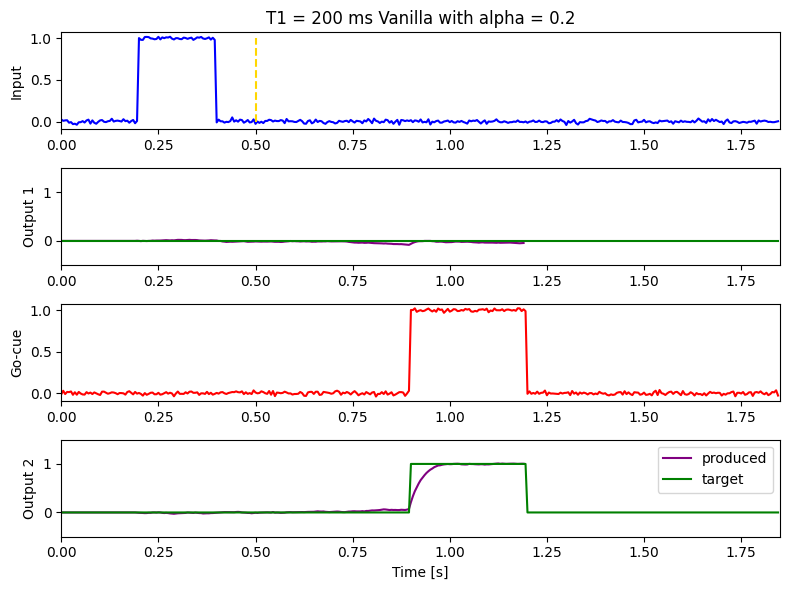

In [ ]:
inputs, labels, starts, ends, Ts, obj = get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = get_data(inputs, labels)

with torch.no_grad():
  scores = torch.zeros(targets.shape)
  hidden = torch.zeros(batch_size, len(tv), hidden_size)
  for b in range(batch_size):
    scores1, hidden1 = model.foward_euler(data, ends, b, alpha)
    hidden[b, :, :] = hidden1
    scores1[0, :int(starts[0, b] - 1), :] *= 0
    scores[b, :int(ends[0, b]), :] = scores1

n = 1
title = "T1 = " + str(int(T2s[n] * step * 1e3)) + " ms" + \
        " Vanilla with alpha = 0.2"
plot_trial(n, title)

### Weights

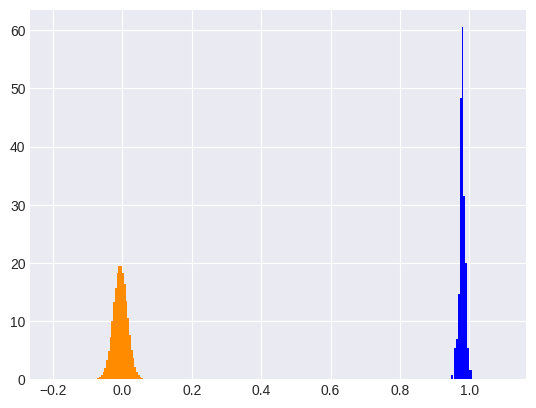

In [ ]:
pesos = model.i2h.weight[:,2:].detach().numpy()
bin = np.linspace(-0.2,1.1,256)
plt.hist(pesos.flatten(),bins=bin,color="darkorange",density=True)
plt.hist(np.diag(pesos),bins=bin,color="blue",density=True)
plt.show()

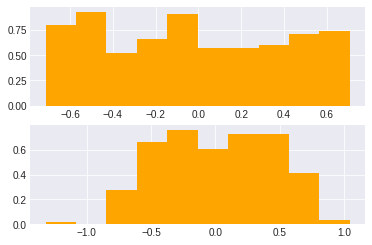

In [ ]:
pesos = model.i2h.weight[:,0:2].detach().numpy()
plt.subplot(211)
plt.hist(pesos[:,0].flatten(),color="orange",density=True)
plt.subplot(212)
plt.hist(pesos[:,1].flatten(),color="orange",density=True)
plt.show()

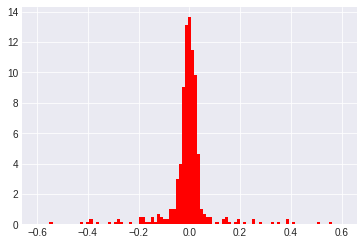

In [ ]:
pesos = model.h2o.weight.detach().numpy()
bin = np.linspace(-0.6,0.6,100)
plt.hist(pesos.flatten(),bins=bin,color="red",density=True)
plt.show()

### Activity

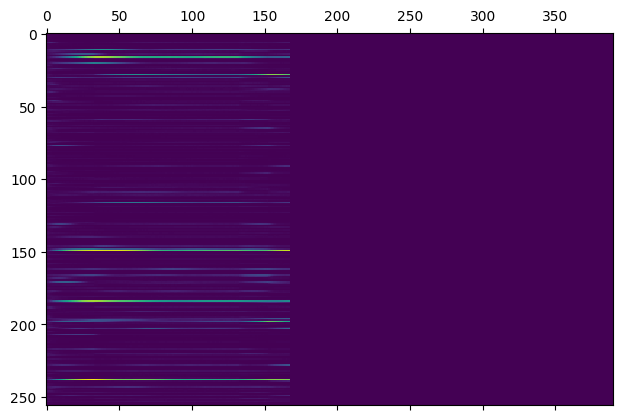

In [ ]:
plt.style.use('default')
oculton = hidden.detach().numpy()
plt.matshow(oculton[5,:,:].transpose())
plt.show()

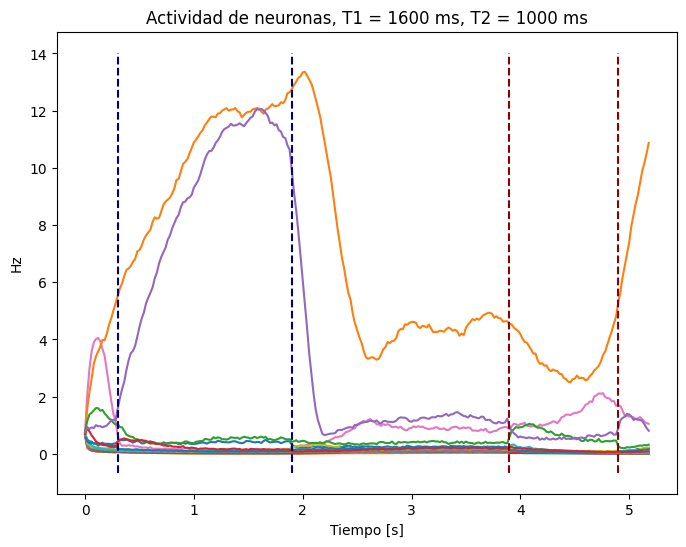

In [ ]:
n = 2
plt.figure(figsize=(8,6))

for neu in range(15):
  plt.plot(tv[:int(ends[0,n])],oculton[n,:int(ends[0,n]),neu])

axes = plt.gca()
yi, ys = axes.get_ylim()
plt.vlines([tv[int(starts[0,n])],tv[int(starts[0,n]+T2s[0,n])],tv[int(starts[0,n]+T2s[0,n]+T3s[0,n])],tv[int(starts[0,n]+T2s[0,n]+T3s[0,n]+T2s[1,n])]],yi,ys, color=["navy","navy","darkred","darkred"],linestyles="dashed")
plt.title("Actividad de neuronas, T1 = "+str(int(T2s[0,n]*20))+" ms, T2 = "+str(int(T2s[1,n]*20))+" ms")
plt.ylabel("Hz")
plt.xlabel("Tiempo [s]")
plt.savefig("ICT_an.svg")
plt.show()